In [1]:
import skimage.io as io
import numpy as np
from src.functions.image_utils import gaussian_focus_stacker, LoG_focus_stacker
from src.functions.utilities import path_leaf
import os
import glob2 as glob
from skimage.transform import resize
from matplotlib import pyplot as plt
import torch

In [2]:
# set path to image files
experiment_date = "20230613"
root = "/media/nick/hdd01/data/morphseq/built_image_data/"
stacked_image_path = os.path.join(root, "keyence_stitched_z", experiment_date, "")
seg_image_path = os.path.join(root, "segmentation", experiment_date, "")

# get list of image stacks
image_list = sorted(glob.glob(stacked_image_path + "*.tif"))

### Load a sample image stack

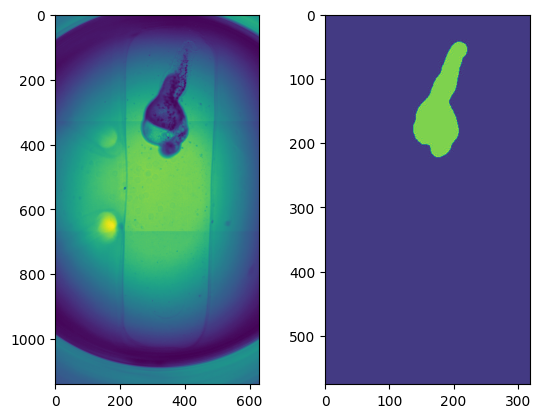

In [12]:
im_ind = 131
im_path = image_list[im_ind]
im_name = path_leaf(im_path)

# load stack
im_stack = io.imread(im_path)

# load mask
mask_path = seg_image_path + im_name[:9] + "_stitch.jpg"
im_mask = io.imread(mask_path)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(im_stack[15, :, :])
axarr[1].imshow(im_mask)
plt.show()                    

### Calculate FF using standard method

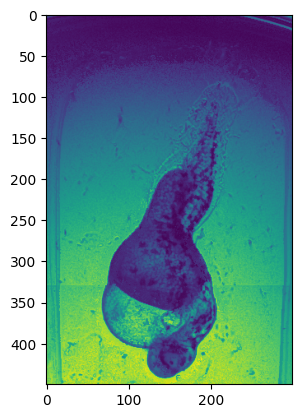

In [13]:
im_FF, log_maxima = LoG_focus_stacker(torch.tensor(im_stack.astype(np.double)), filter_size=3, device="cpu")

plt.imshow(im_FF[0:450, 200:500])
plt.show()

### What if we used a z stack with half the the z resolution?

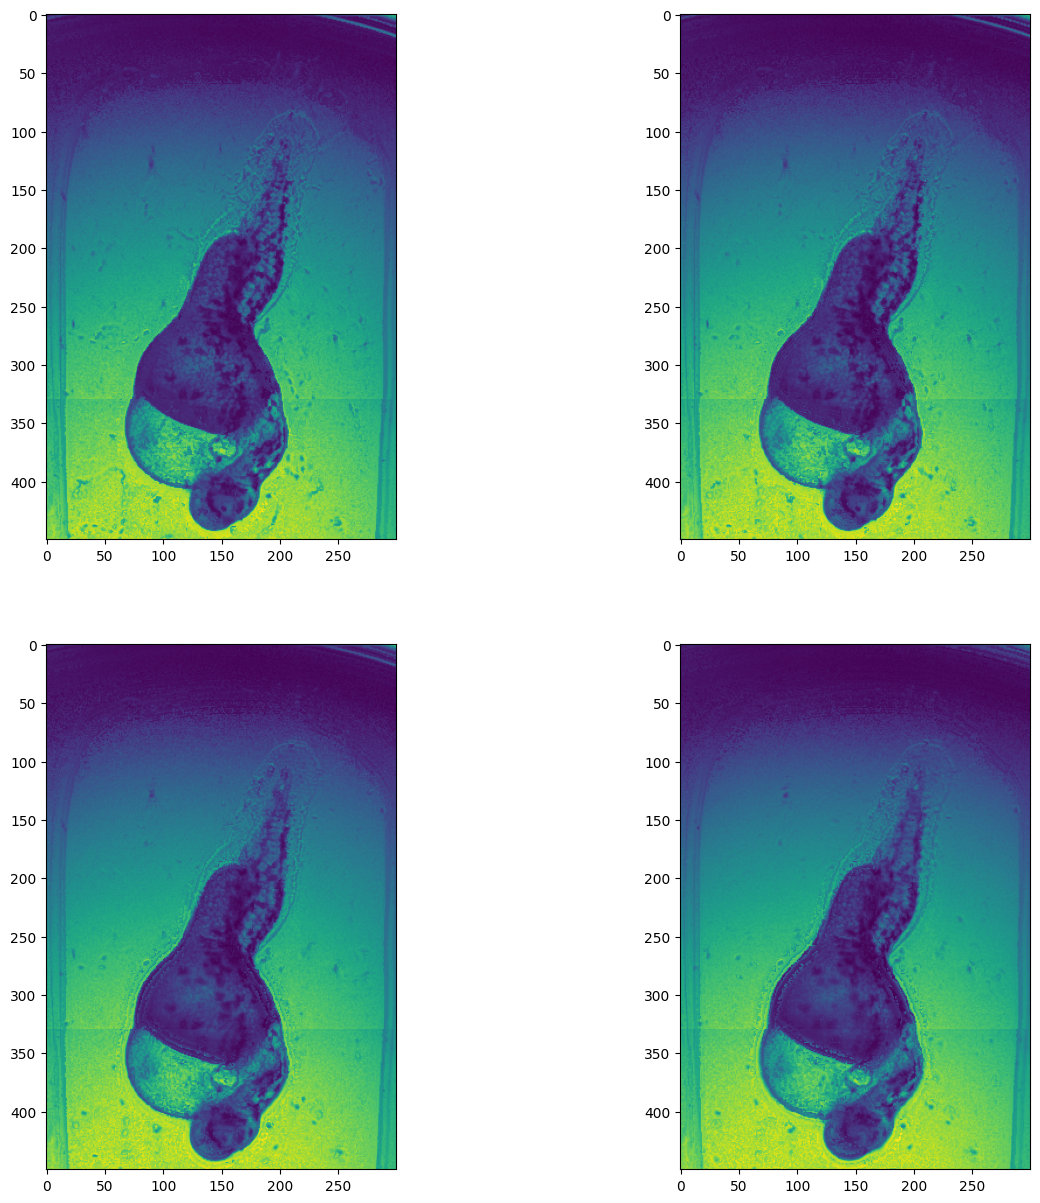

In [14]:
im_stack_ds = im_stack[np.arange(0, im_stack.shape[0], 2), :, :]
im_stack_ds2 = im_stack[np.arange(0, im_stack.shape[0], 4), :, :]
im_stack_ds3 = im_stack[np.arange(0, im_stack.shape[0], 6), :, :]
im_FF_ds, _ = LoG_focus_stacker(torch.tensor(im_stack_ds.astype(np.double)), filter_size=3, device="cpu")
im_FF_ds2, _ = LoG_focus_stacker(torch.tensor(im_stack_ds2.astype(np.double)), filter_size=3, device="cpu")
im_FF_ds3, _ = LoG_focus_stacker(torch.tensor(im_stack_ds3.astype(np.double)), filter_size=3, device="cpu")

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(im_FF[0:450, 200:500])
axarr[0,1].imshow(im_FF_ds[0:450, 200:500])
axarr[1,0].imshow(im_FF_ds2[0:450, 200:500])
axarr[1,1].imshow(im_FF_ds3[0:450, 200:500])
f.set_figheight(15)
f.set_figwidth(15)
plt.show()      

To my eye, the 2x reduction in z resolution so 80um has almost no impact on quality. Border artifacts a reduction in image sharpness are evident once we go further.

### What if we just take the most in-focus slice?

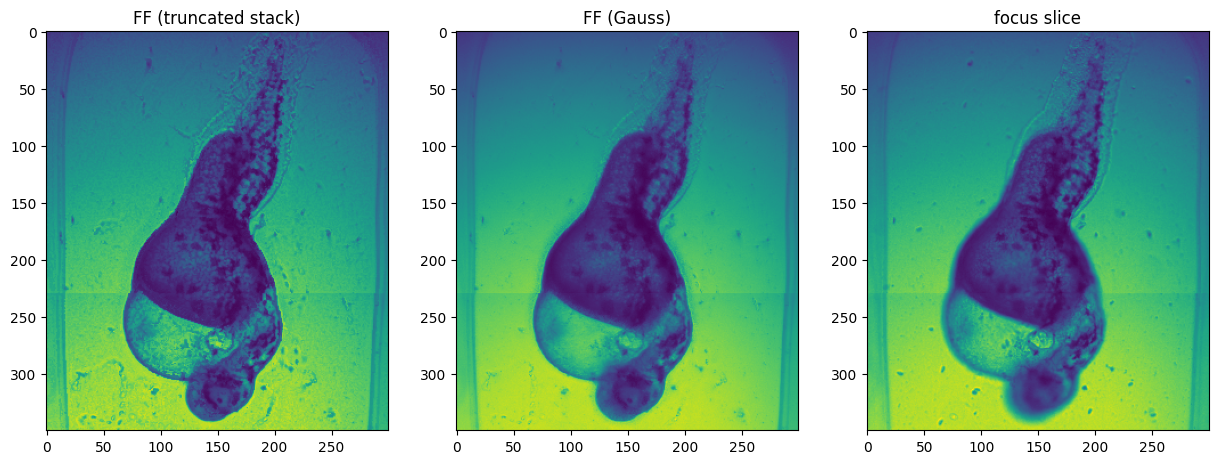

In [15]:
# resize the mask
im_mask_rs = resize(im_mask, im_stack.shape[1:], order=0, preserve_range=True)

# turncate the stack
im_stack_trunc = im_stack[6:-6, :, :] # simulate a narrower stack
im_FF, im_laps = LoG_focus_stacker(torch.tensor(im_stack_trunc.astype(np.double)), filter_size=3, device="cpu")
im_FF_g = gaussian_focus_stacker(torch.tensor(im_stack_trunc.astype(np.double)), filter_size=3, device="cpu")

im_laps = np.asarray(im_laps)

focus_vec = np.empty((im_stack_trunc.shape[0]))
for z in range(im_stack_trunc.shape[0]):
    lap_slice = im_laps[z]
    mean_lap = np.mean(lap_slice[im_mask_rs>0])
    focus_vec[z] = mean_lap

best_z = np.argmax(focus_vec)

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(im_FF[100:450, 200:500])
axarr[1].imshow(im_FF_g[100:450, 200:500])
axarr[2].imshow(im_stack_trunc[best_z, 100:450, 200:500])
axarr[0].title.set_text('FF (truncated stack)')
axarr[1].title.set_text('FF (Gauss)')
axarr[2].title.set_text('focus slice')
f.set_figheight(10)
f.set_figwidth(15)
plt.show()    

In [7]:
focus_vec

array([3.56354184, 3.64509816, 3.73839007, 3.83205931, 3.87403752,
       3.76218445, 3.68406433, 3.57884538, 3.46506509, 3.38447838,
       3.32979915, 3.30297584])

In [8]:
im_laps

array([[[2.20125e+02, 2.20500e+02, 1.79500e+02, ..., 1.91500e+02,
         2.40125e+02, 2.36000e+02],
        [2.24250e+02, 1.70250e+02, 9.30000e+01, ..., 9.75000e+01,
         1.79500e+02, 2.37250e+02],
        [1.82125e+02, 9.36250e+01, 1.87500e+00, ..., 7.50000e-01,
         9.25000e+01, 1.89625e+02],
        ...,
        [9.86250e+01, 4.97500e+01, 1.25000e-01, ..., 2.50000e+00,
         5.36250e+01, 1.08375e+02],
        [1.22125e+02, 9.00000e+01, 4.72500e+01, ..., 5.62500e+01,
         1.05625e+02, 1.38875e+02],
        [1.20500e+02, 1.19500e+02, 9.51250e+01, ..., 1.17125e+02,
         1.46500e+02, 1.43875e+02]],

       [[2.26125e+02, 2.25250e+02, 1.81750e+02, ..., 1.88375e+02,
         2.38750e+02, 2.38250e+02],
        [2.28375e+02, 1.70750e+02, 9.41250e+01, ..., 9.62500e+01,
         1.82250e+02, 2.40875e+02],
        [1.83125e+02, 9.28750e+01, 4.62500e+00, ..., 8.75000e-01,
         9.93750e+01, 1.96125e+02],
        ...,
        [9.71250e+01, 4.88750e+01, 1.00000e+00, ..., 1